**Checked files in the directory.............**

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/air-quality-madrid/stations.csv
/kaggle/input/air-quality-madrid/madrid.h5
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2016.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2015.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2007.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2008.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2005.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2011.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2003.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2004.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2012.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2001.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2014.csv
/kaggle/input/air-quality-madrid/csvs_per_year/csvs_per_year/mad

# Forecasting ozone level in madrid...............

**Import libraies.................**

In [21]:
import glob
import missingno as msno
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
import itertools
from pandas import Series
from pandas import datetime
import folium
import matplotlib.dates 
from datetime import datetime, timedelta
from scipy import stats
from itertools import product
from math import sqrt
from pandas import DataFrame
from pandas import Grouper
from pandas import concat
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore") 
plt.style.use('seaborn-whitegrid')
%matplotlib  inline

In [3]:
print(os.listdir("../input/air-quality-madrid"))

['csvs_per_year', 'stations.csv', 'madrid.h5']


In [4]:
#set the color for sns plot...............
colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

**Read in data.........**

For Phrobet Model...........

In [5]:
path =r'../input/air-quality-madrid/csvs_per_year/csvs_per_year/' 
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

cols = ['date', 'station', 'BEN', 'CH4', 'CO', 'EBE', 'MXY', 'NMHC', 'NO', 'NO_2', 'NOx', 'OXY', 'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL']
frame = frame[cols]
frame = frame.sort_values(['station', 'date'])
frame.tail(3)

,date,station,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL
85821,2010-12-31 22:00:00,28079099,2.07,NaN,0.70,1.30,NaN,0.26,NaN,77.139999,155.899994,NaN,4.98,24.450001,16.25,NaN,12.99,1.56,4.11
85846,2010-12-31 23:00:00,28079099,1.49,NaN,0.62,1.14,NaN,0.26,NaN,68.290001,128.000000,NaN,5.24,22.240000,14.09,NaN,12.86,1.63,3.32
85871,2011-01-01 00:00:00,28079099,1.11,NaN,0.48,0.86,NaN,0.23,NaN,53.529999,82.430000,NaN,6.85,19.450001,14.54,NaN,11.71,1.66,2.46


In [11]:
#where are the stations...........
stations = pd.read_csv('../input/air-quality-madrid/stations.csv')
stations.head(1)

,id,name,address,lon,lat,elevation
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635


For LSTM Model.............

We will use the records of a single station, 28079016, which is one of the few that were active the whole 18 years period we are using to tune the model. However, not every particle was measured during 18 years, so we have to be careful when choosing which one will be used for the task.

In [6]:
with pd.HDFStore('../input/air-quality-madrid/madrid.h5') as data:
    df = data['28079016']
    
df = df.sort_index()
df.info()

Opening ../input/air-quality-madrid/madrid.h5 in read-only mode
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151776 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   CO      151182 non-null  float64
 1   NO      64045 non-null   float64
 2   NO_2    151290 non-null  float64
 3   NOx     92321 non-null   float64
 4   O_3     151131 non-null  float64
 5   PM10    75920 non-null   float64
 6   SO_2    78497 non-null   float64
dtypes: float64(7)
memory usage: 9.3 MB


For SARIMAX prediction of PM10......

In [14]:
series = pd.read_csv('../input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2016.csv')
print(series.shape)

stations = pd.read_csv('../input/air-quality-madrid/stations.csv')
stations_=stations[stations['id'] == 28079008]
locations  = stations_[['lat', 'lon']]
#locations=locations[locations['id'] == 28079008]
locationlist = locations.values.tolist()

(209496, 14)


**EDA.........................**

*Missing data....................*

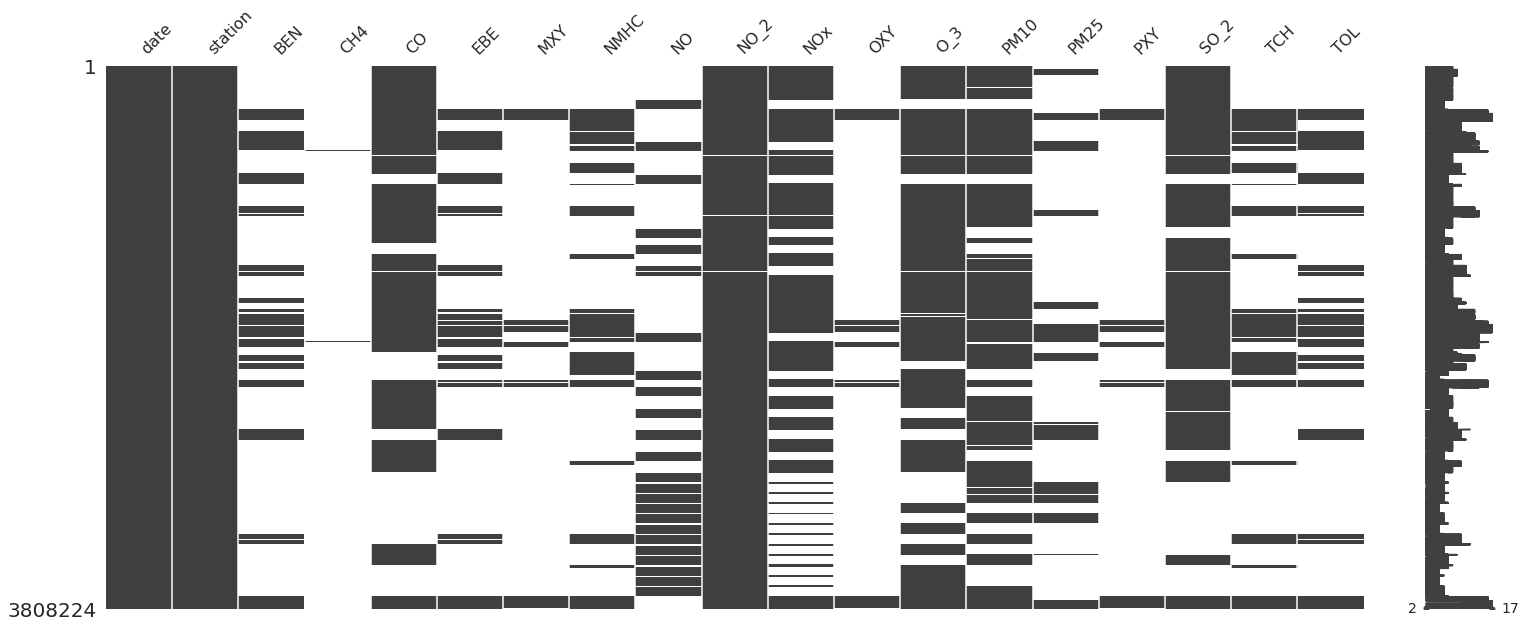

In [8]:
msno.matrix(frame)

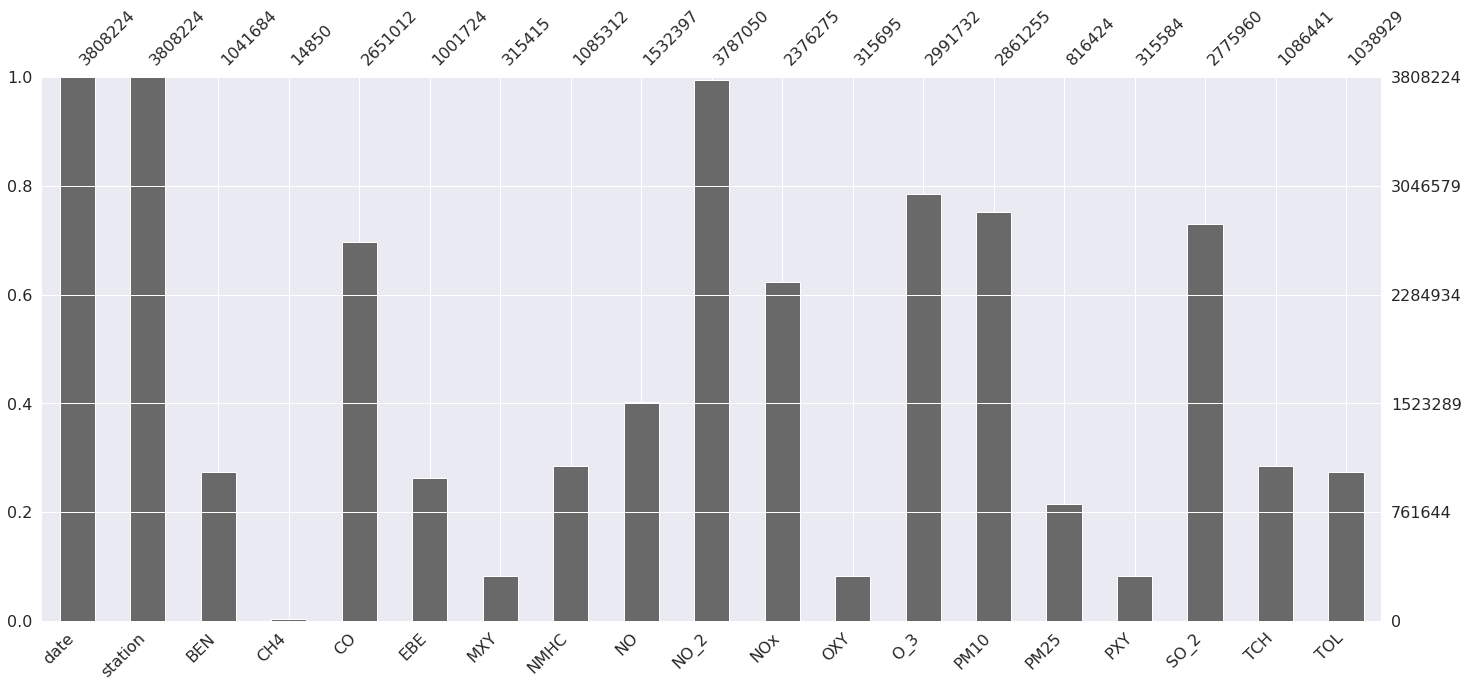

In [9]:
msno.bar(frame)

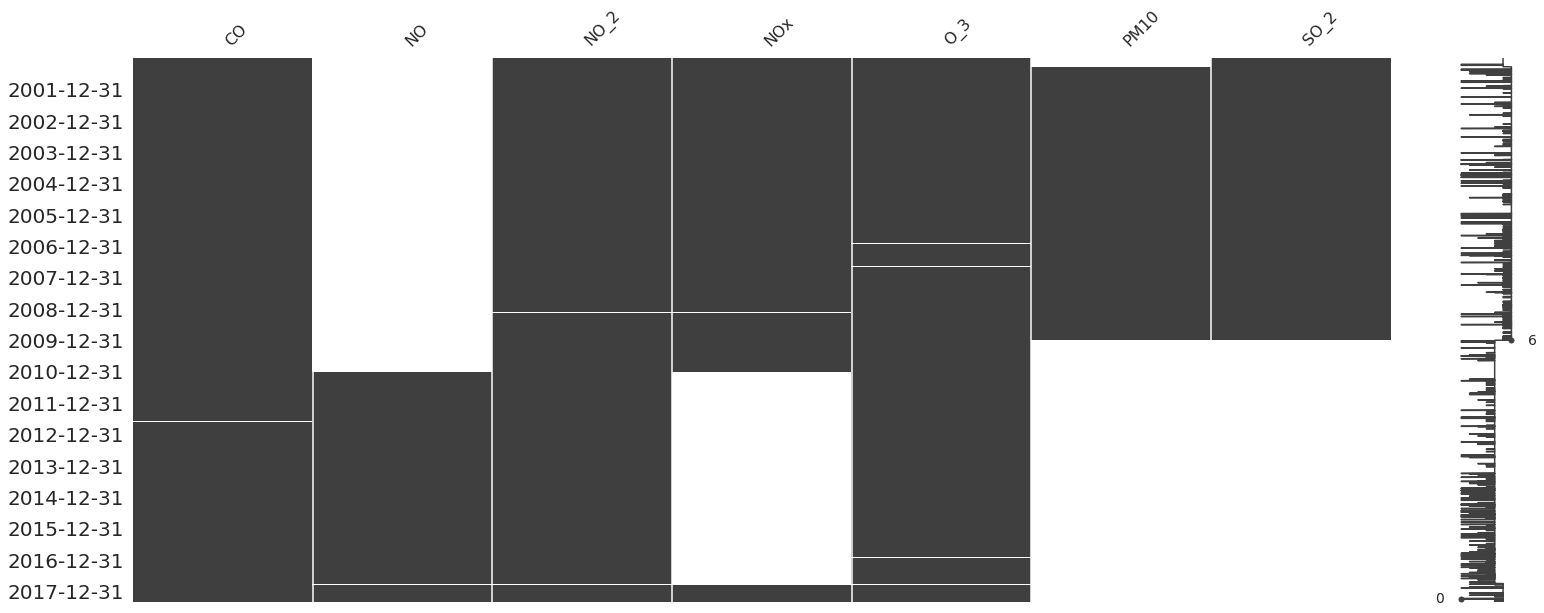

In [10]:
msno.matrix(df, freq='Y')

*Mark the stations....................*

In [12]:
#1
locations  = stations[['lat', 'lon']]
locationlist = locations.values.tolist()
popup = stations[['name']]
map_osm = folium.Map(location=[40.44, -3.69],
                    # tiles='Stamen Toner',
                     zoom_start=11) 
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=popup.iloc[point,0]).add_to(map_osm)
    
map_osm

In [15]:
#3
#After exploring the data we have selected a station with a relevant amount of PM10 data.
popup = stations[['name']]
map_osm = folium.Map(location=[40.44, -3.69],
                    # tiles='Stamen Toner',
                     zoom_start=11) 
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=popup.iloc[point,0]).add_to(map_osm)
display(map_osm)

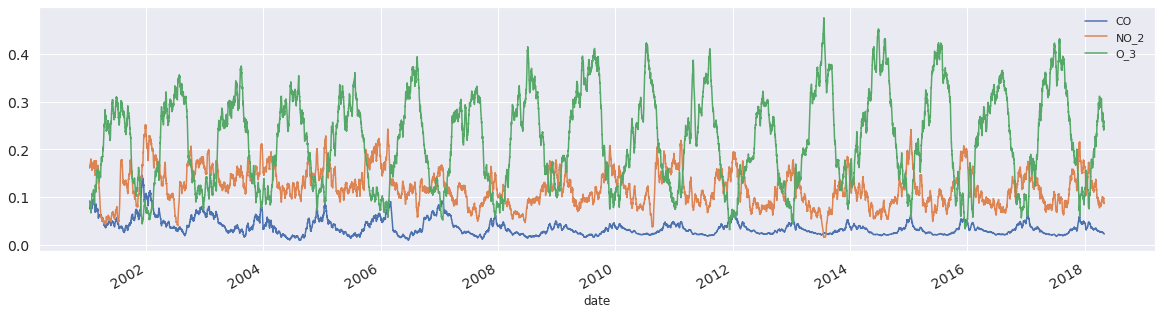

In [16]:
#2
fig, ax = plt.subplots(figsize=(20, 5))
candidates = df[['CO', 'NO_2', 'O_3']] 
candidates /= candidates.max(axis=0)
(candidates.interpolate(method='time').rolling(window=24*15).mean().plot(ax=ax))

In [17]:
#3
#Nan values are filled with the last correct value registered
station1 = series[series['station'] == 28079008].fillna(method='ffill')
#We will select PM10 
station1 = station1[['date', 'PM10']]
#convert date to datetime format 
station1['date'] = pd.to_datetime(station1['date'])
#We sort values by date
station1=station1.sort_values(by='date')
#The new index will be the date
station1=station1.reset_index(drop=True)
station1.set_index('date',inplace=True)

In [18]:
#3
# Convert PM10 values to float
myDataset = pd.DataFrame(station1['PM10'])
Dataset = myDataset['PM10'].values
Dataset = Dataset.astype('float32')
Dataset=station1['PM10']
X=Dataset
#Adjust frequency
X.index = pd.DatetimeIndex(X.index.values,freq=X.index.inferred_freq)
#We eliminate outliers( if PM10 > 150)
for (i, item) in enumerate(X):
    if item > 150:
        X[i] = np.mean(X)
#list with the dataset
history = [X for X in X]
print('dataset')
print(X)

dataset
2016-01-01 01:00:00    17.0
2016-01-01 02:00:00    27.0
2016-01-01 03:00:00    49.0
2016-01-01 04:00:00    49.0
2016-01-01 05:00:00    47.0
                       ... 
2016-12-31 20:00:00    25.0
2016-12-31 21:00:00    25.0
2016-12-31 22:00:00    31.0
2016-12-31 23:00:00    35.0
2017-01-01 00:00:00    33.0
Freq: H, Name: PM10, Length: 8784, dtype: float64


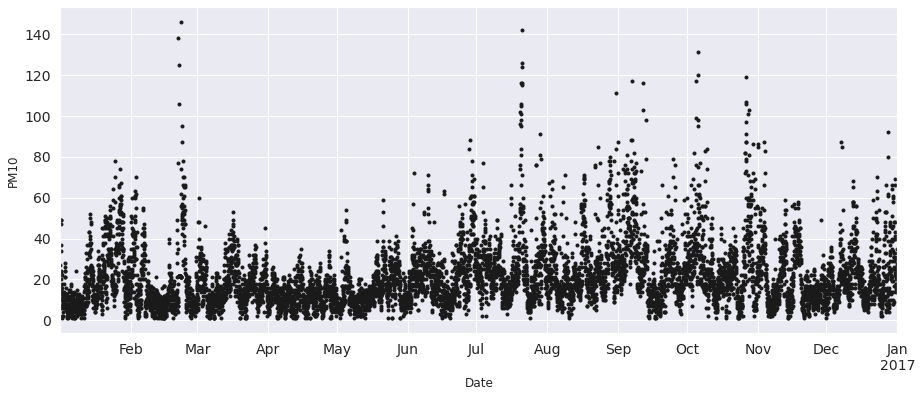

In [19]:
#3
#Plot PM10 values in 2016
X.plot(figsize=(15, 6),style='k.')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.show()

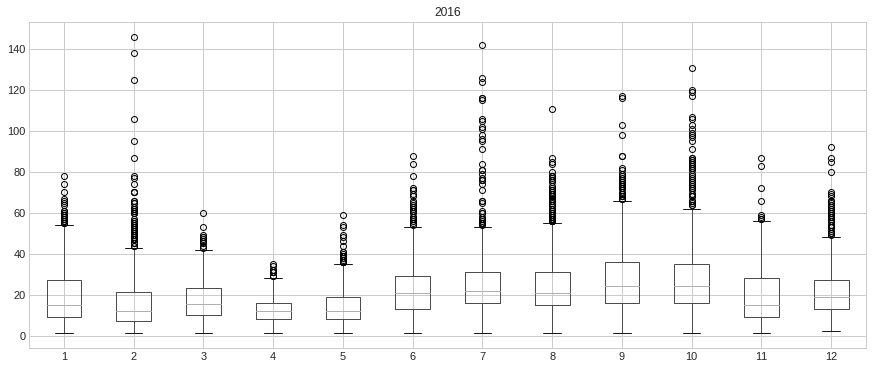

Month: 1
count    743.000000
mean      19.983849
std       14.736857
min        1.000000
25%        9.000000
50%       15.000000
75%       27.000000
max       78.000000
Name: 1, dtype: float64
Month: 2
count    696.000000
mean      17.709389
std       17.457294
min        1.000000
25%        7.000000
50%       12.000000
75%       21.416888
max      146.000000
Name: 2, dtype: float64
Month: 3
count    744.000000
mean      17.051075
std        9.720873
min        1.000000
25%       10.000000
50%       15.500000
75%       23.000000
max       60.000000
Name: 3, dtype: float64
Month: 4
count    720.000000
mean      12.184722
std        6.217257
min        1.000000
25%        8.000000
50%       12.000000
75%       16.000000
max       35.000000
Name: 4, dtype: float64
Month: 5
count    744.000000
mean      14.653226
std        8.923824
min        1.000000
25%        8.000000
50%       12.000000
75%       19.000000
max       59.000000
Name: 5, dtype: float64
Month: 6
count    720.000000
mean  

In [23]:
#3
#Boxplot Statistics in 2016
def parse(x):
    return pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
i=0
graph1=list()
months2=list()
for year in [2016]:
    i+=1
    year2=str(year)
    one_year = X[year2]
    groups = one_year.groupby(Grouper(freq = '1M'))
    months = concat([DataFrame(x[1].values) for x in groups], axis=1)
    months = DataFrame(months)
    months.columns =range(1,13)
    months2.append(months)
    graph1=months.boxplot(figsize=(15, 6))
    plt.title(year2)
    plt.show()
stats=list()
for i in range(len(months.columns)):
    print('Month:',i+1)
    stats.append(months[i+1].describe())
    print(stats[i])

**Data Preparation for Model....................**

For Prophet Model.....................

*Based on extensive scientific evidence about the effects of ozone on public health and welfare, on October 1, 2015, EPA strengthened the ground-level ozone standard to 0.070 ppm, averaged over an 8-hour period. This standard is met at an air quality monitor when the 3-year average of the annual fourth-highest daily maximum 8-hour average ozone concentration is less than or equal to 0.070 ppm....*

In [24]:
#Eight-Hour Average Ozone Concentrations
cols = ['date', 'station', 'O_3']
o3 = frame[cols]
o3['date'] = pd.to_datetime(o3['date'])
o3['ppb'] = 24.45*o3['O_3'] /48
o3.head(2)

,date,station,O_3,ppb
108960,2001-01-02 01:00:00,28079001,NaN,NaN
108986,2001-01-02 02:00:00,28079001,NaN,NaN


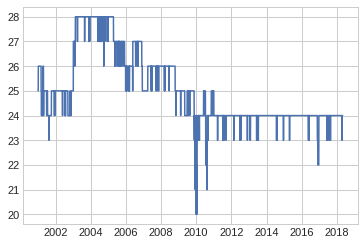

In [25]:
#active stations with time
plt.plot(o3.groupby(['date']).station.nunique())

In [26]:
#non-nulls per station
count_rows = pd.DataFrame(o3.groupby(['station']).O_3.count())
top3 = count_rows.sort_values('O_3', ascending=False).head(3)
print(top3)

             O_3
station         
28079016  151131
28079024  149135
28079018  149067


In [27]:
stations[stations.id == top3.index[0]]

,id,name,address,lon,lat,elevation
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693


In [28]:
#select station with most data
o3_station = o3[o3.station == top3.index[0]]

#Calculate Eight-Hour Average Ozone Concentrations
o3_station['ppb_rolling'] = o3_station['ppb'].rolling(8).mean()

In [29]:
o3_station = o3_station.fillna(0)
del o3_station['station']
del o3_station['O_3']
del o3_station['ppb']
o3_station = o3_station.sort_values("date")
o3_station.columns = ['ds', 'y']
o3_station.set_index('ds', inplace=True)

In [30]:
grouped = o3_station.groupby(pd.Grouper(freq='D'),as_index=False)
#z = grouped['power'].max()
print(type(grouped))
grouped.head(3)

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


,y
ds,
2001-01-01 01:00:00,0.000000
2001-01-01 02:00:00,0.000000
2001-01-01 03:00:00,0.000000
2001-01-02 00:00:00,13.844813
2001-01-02 01:00:00,15.337281
...,...
2018-04-29 02:00:00,39.985937
2018-04-30 00:00:00,37.693750
2018-04-30 01:00:00,37.057031


In [31]:
#Resample to daily max
#o3_station = o3_station.resample('D', how='max')
#o3_station = o3_station.loc[o3_station.groupby(pd.Grouper(freq='D')).idxmax().iloc[:, 0]]
o3_station = grouped
o3_station = grouped.apply(lambda x: x) 
# Any missing dates?
d = pd.DataFrame(pd.date_range(start= o3_station.index.min(), end= o3_station.index.max(), freq='D'))

o3_station.reset_index(level=0, inplace=True)
o3_station = d.join(o3_station)

In [32]:
del o3_station['ds']
o3_station.columns = ['ds', 'y']
#fill na 
o3_station['y'].fillna(0, inplace=True)

In [33]:
# 3 years in hours
i = 3*365 
# Train test split 
train = o3_station[1:-i]
test = o3_station[-i:]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5233 entries, 1 to 5233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5233 non-null   datetime64[ns]
 1   y       5233 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 81.9 KB


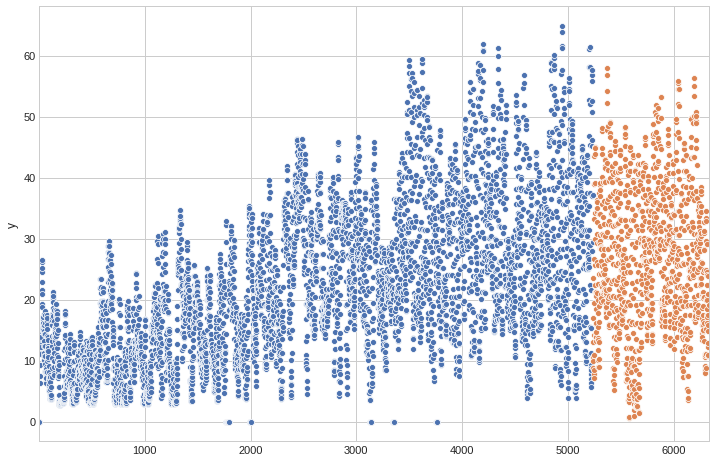

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.scatterplot(x=train.index, y=train.y)
ax = sns.scatterplot(x=test.index, y=test.y)
ax.axes.set_xlim(train.index.min(), test.index.max());

In [35]:
train.reset_index(level=0, inplace=True)
test.reset_index(level=0, inplace=True)

train['y'] = np.log1p(train.y)
test['y'] = np.log1p(test.y)

train.head(5)

,index,ds,y
0,1,2001-01-02 01:00:00,0.0
1,2,2001-01-03 01:00:00,0.0
2,3,2001-01-04 01:00:00,0.0
3,4,2001-01-05 01:00:00,0.0
4,5,2001-01-06 01:00:00,0.0


For LSTM Model............

*To prepare the data for the task, we will apply several steps to it. To smooth the variation in the curve to be predicted and be able to properly reconstruct it, we are going to apply the natural logarithm to the data. Also, our target is to input 24 timesteps to the network (a complete day, containing 24 hourly records) and make the network predict the next 24 timesteps (the next day). To do so, we want to pivot the next 48 hours for each sample into columns. We will apply this to the whole dataset and after it select the training examples with a 50% overlap: we will make a prediction not only at midnight but also at noon, which will force the data to be more general and generate twice as many examples......*

In [36]:
def pivot_with_offset(series, offset):
    pivot = pd.DataFrame(index=df.index)

    for t in range(offset * 2):
        pivot['t_{}'.format(t)] = series.shift(-t)

    pivot = pivot.dropna(how='any')
    return pivot

In [37]:
offset = 24
series = (df.NO_2.interpolate(method='time')
                 .pipe(pivot_with_offset, offset)
                 .apply(np.log, axis=1)
                 .replace(-np.inf))

# Get only timestamps at 00:00 and 12:00
series = series[(series.index.hour % 12) == 0]
# Make it a multiple of the chosen batch_size
if series.shape[0] % 32 != 0:
    series = series.iloc[:-(series.shape[0]%32)]

*The next step is to split the series into features and labels: the first 24 hours of each row will be used to predict (X) and the next 24 hours will be the levels that we aim to predict (y). Also we need to split before starting to do more data processing into train and test data: 20% of the data will not be used for learning. Instead, it will be used to check that the model is able to generalize to new data properly. Take into account that these are time-stamped data and we are training a stateful network: make sure that the data is kept in its original order!........*

In [38]:
test_ratio = 0.2
split_point = int(series.shape[0] * (1 - test_ratio))
split_point -= split_point % 32
np_series = series.values

X_train = series.values[:split_point , :offset]
y_train = series.values[:split_point, offset:]
X_test = series.values[split_point:, :offset]
y_test = series.values[split_point:, offset:]

*Also, it is important to notice that Keras requires a certain shape for the input data: a three dimensional input array with the shape (batch-size, timesteps, features). If we are going predict 24 hours based solely on the previous 24 hours records, we have 24 timesteps and 1 single feature (the NO_2 levels). We also want the data to be scaled in the interval  [0,1] .........*

In [39]:
# Scale only to train data to prevent look-ahead bias
lift = X_train.min()
scale = X_train.max()

def scale_array(arr, lift, scale):
    return (arr - lift) / scale

X_train = np.expand_dims(scale_array(X_train, lift, scale), axis=2)
y_train = np.expand_dims(scale_array(y_train, lift, scale), axis=2)
X_test = np.expand_dims(scale_array(X_test, lift, scale), axis=2)
y_test = np.expand_dims(scale_array(y_test, lift, scale), axis=2)

**Build the Model......................**

Modelling with fbprophet.............

In [40]:
m = Prophet(changepoint_prior_scale=0.01) 
m.fit(train)

In [41]:
#predict using the model...................
future = m.make_future_dataframe(periods=i, freq='D')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6323,2018-04-26 01:00:00,3.437565,2.630429,4.188188
6324,2018-04-27 01:00:00,3.458398,2.733982,4.174380
6325,2018-04-28 01:00:00,3.471910,2.738377,4.156444
6326,2018-04-29 01:00:00,3.494431,2.774937,4.232745
6327,2018-04-30 01:00:00,3.510544,2.771130,4.171581


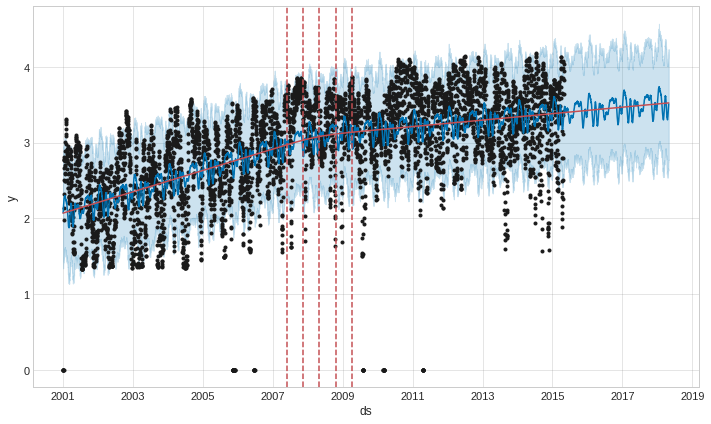

In [42]:
from  fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

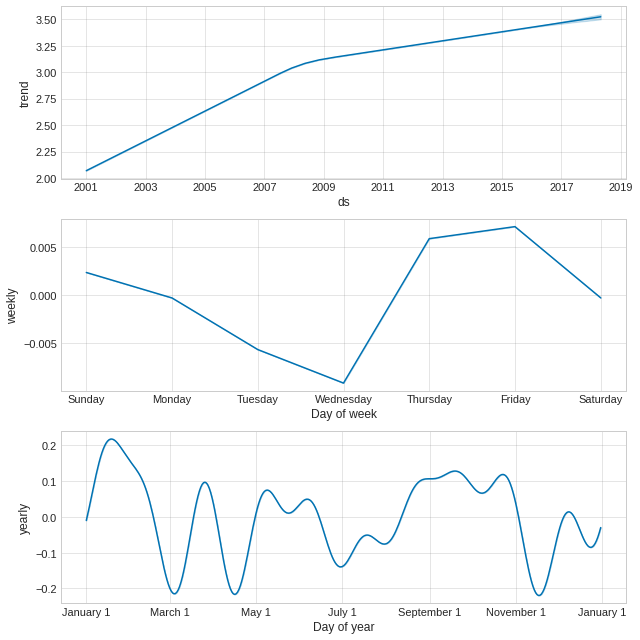

In [43]:
fig2 = m.plot_components(forecast)

In [44]:
test = pd.concat([test.set_index('ds'),forecast.set_index('ds')], axis=1, join='inner')

cols = ['y', 'yhat', 'yhat_lower', 'yhat_upper']
test = test[cols]
#test['y'] = np.expm1(test.y)
#test['yhat'] = np.expm1(test.yhat)
#test['yhat_lower'] = np.expm1(test.yhat_lower)
#test['yhat_upper'] = np.expm1(test.yhat_upper)

test.tail()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-04-26 01:00:00,2.465183,3.437565,2.630429,4.188188
2018-04-27 01:00:00,2.475413,3.458398,2.733982,4.174380
2018-04-28 01:00:00,2.633942,3.471910,2.738377,4.156444
2018-04-29 01:00:00,2.827322,3.494431,2.774937,4.232745
2018-04-30 01:00:00,2.999530,3.510544,2.771130,4.171581


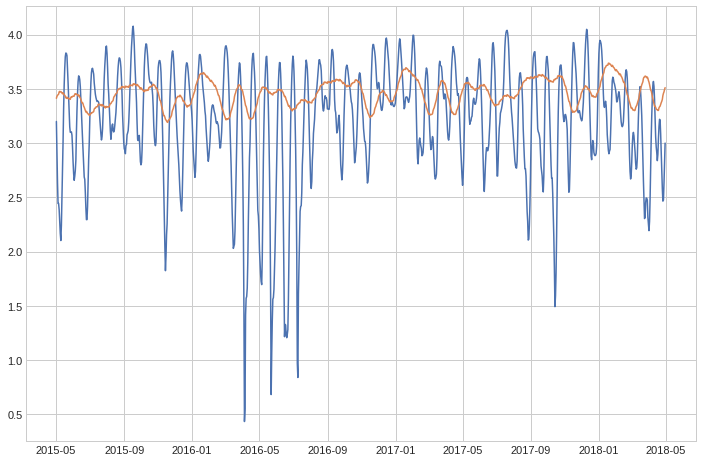

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

plt.plot(test.y)
plt.plot(test.yhat)
plt.legend()

In [46]:
test['e'] = test.y - test.yhat

rmse = np.round(np.sqrt(np.mean(test.e**2)),2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 2)
print('RMSE =', rmse)
print('MAPE =', mape, '%')

RMSE = 0.61
MAPE = 18.45 %


Modeling with ARIMA..............

In [47]:
cols = ['ds', 'y']
train = train[cols]
train.set_index('ds', inplace=True)
train.head()

,y
ds,
2001-01-02 01:00:00,0.0
2001-01-03 01:00:00,0.0
2001-01-04 01:00:00,0.0
2001-01-05 01:00:00,0.0
2001-01-06 01:00:00,0.0


In [48]:
colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

*Stationarity check and Seasonal decomposition....*

Dickey–Fuller test: p=0.000000


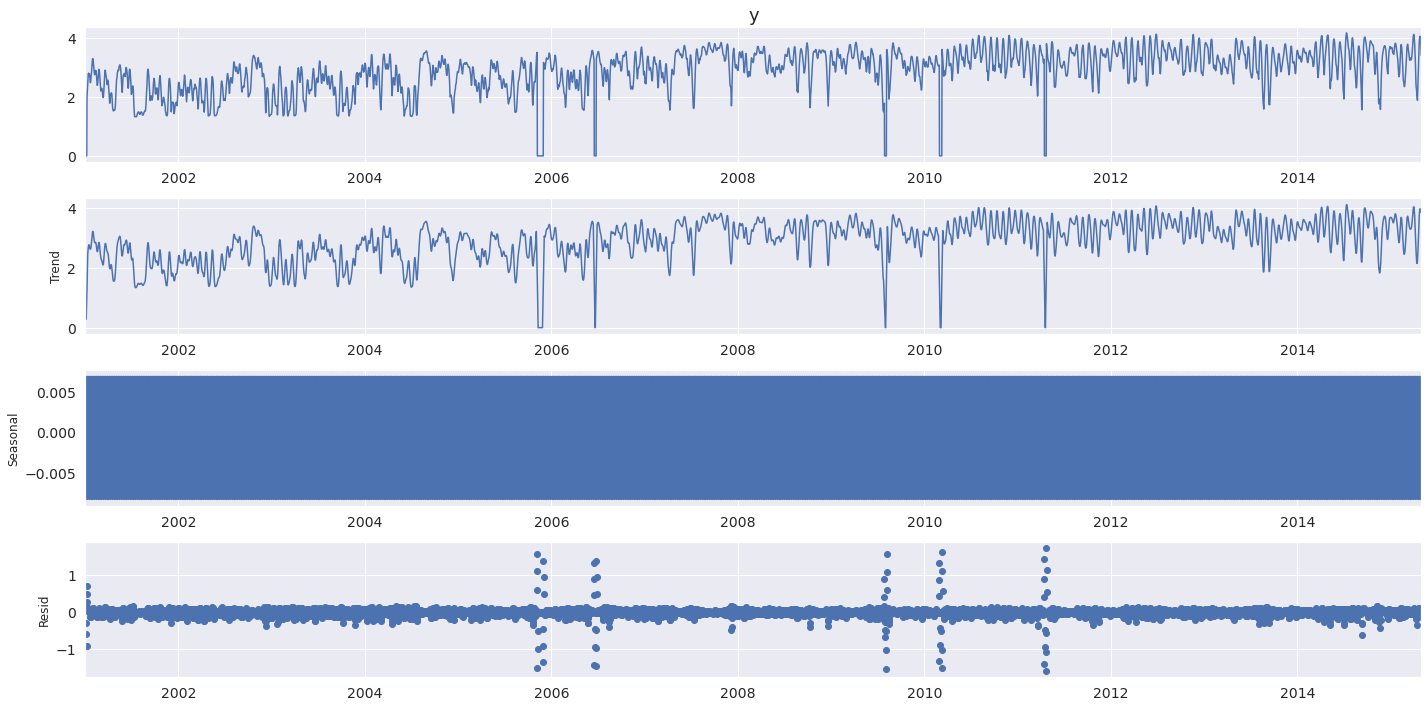

In [49]:
seasonal_decompose(train.y, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(train.y)[1])

*Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots...........*

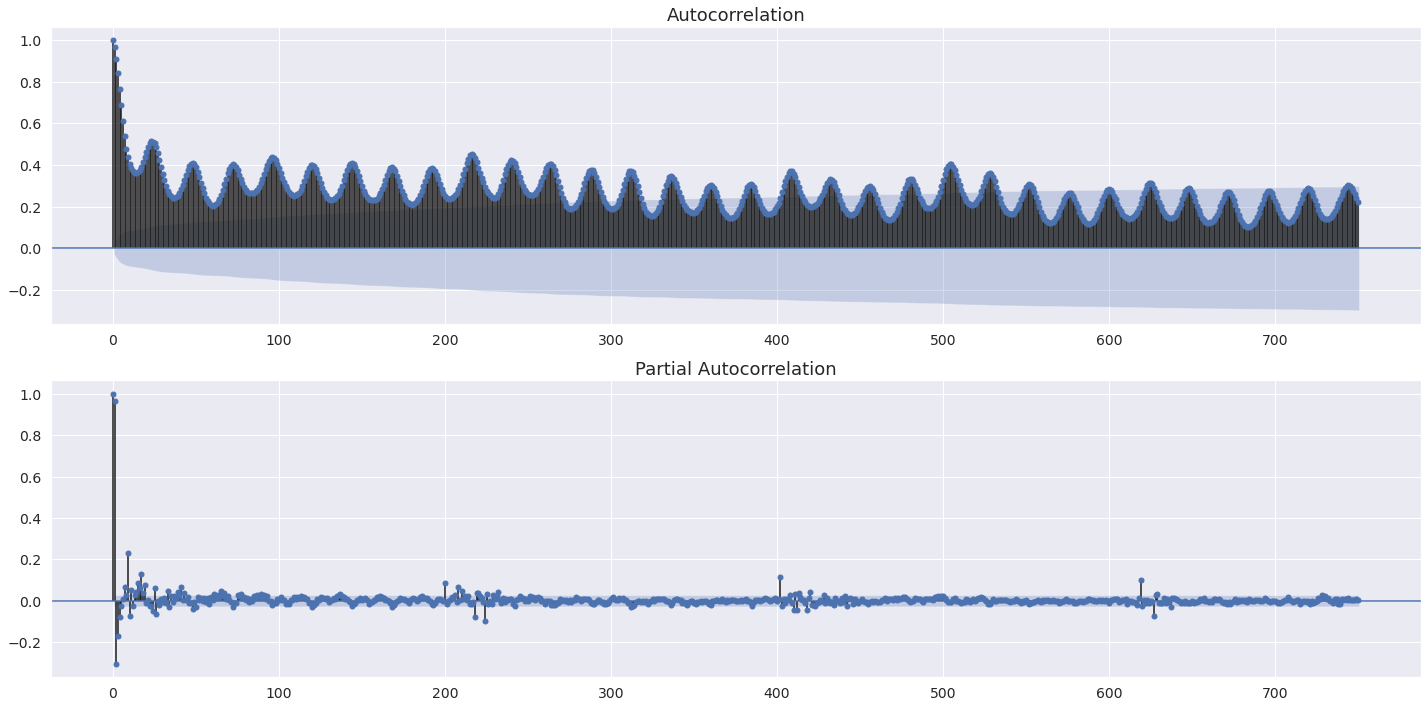

In [50]:
ax = plt.subplot(211)

# Plot the autocorrelation function
plot_acf(train.y[0:].values.squeeze(), lags=750, ax=ax)
ax = plt.subplot(212)
plot_pacf(train.y[0:].values.squeeze(), lags=750, ax=ax)
plt.tight_layout()

*Initial approximation of parameters............*

In [51]:
ps = range(0, 2)
d = 1
qs = range(0, 2)

parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

4

*Model Selection................*

In [52]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(train.y, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

*Best Models.................*

In [53]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
3,"(1, 1)",-3535.163279
2,"(1, 0)",-3450.046302
1,"(0, 1)",-3336.470172
0,"(0, 0)",-2979.181373


In [54]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5233
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1770.582
Date:                Mon, 03 Aug 2020   AIC                          -3535.163
Time:                        19:47:02   BIC                          -3515.476
Sample:                    01-02-2001   HQIC                         -3528.279
                         - 05-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6079      0.026     23.081      0.000       0.556       0.660
ma.L1         -0.3410      0.027    -12.840      0.000      -0.393      -0.289
sigma2         0.0298   4.98e-05    597.896      0.0

In [55]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


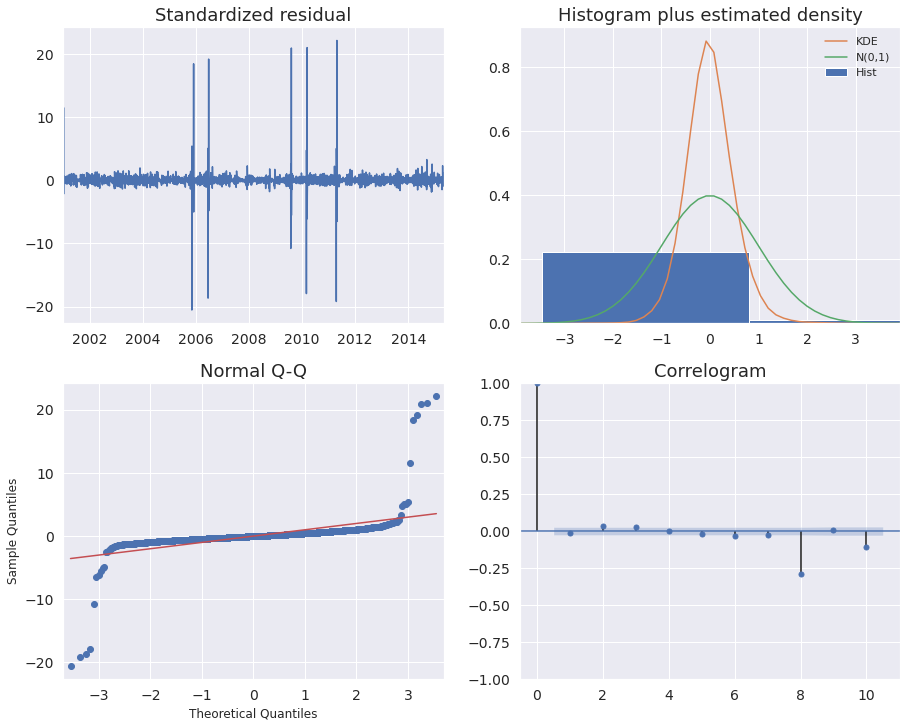

In [56]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [57]:
test['yhat_ARIMA'] = best_model.forecast(test.shape[0])
test.tail()

,y,yhat,yhat_lower,yhat_upper,e,yhat_ARIMA
ds,,,,,,
2018-04-26 01:00:00,2.465183,3.437565,2.630429,4.188188,-0.972382,3.20941
2018-04-27 01:00:00,2.475413,3.458398,2.733982,4.174380,-0.982985,3.20941
2018-04-28 01:00:00,2.633942,3.471910,2.738377,4.156444,-0.837967,3.20941
2018-04-29 01:00:00,2.827322,3.494431,2.774937,4.232745,-0.667109,3.20941
2018-04-30 01:00:00,2.999530,3.510544,2.771130,4.171581,-0.511014,3.20941


Text(0, 0.5, 'parts per billion')

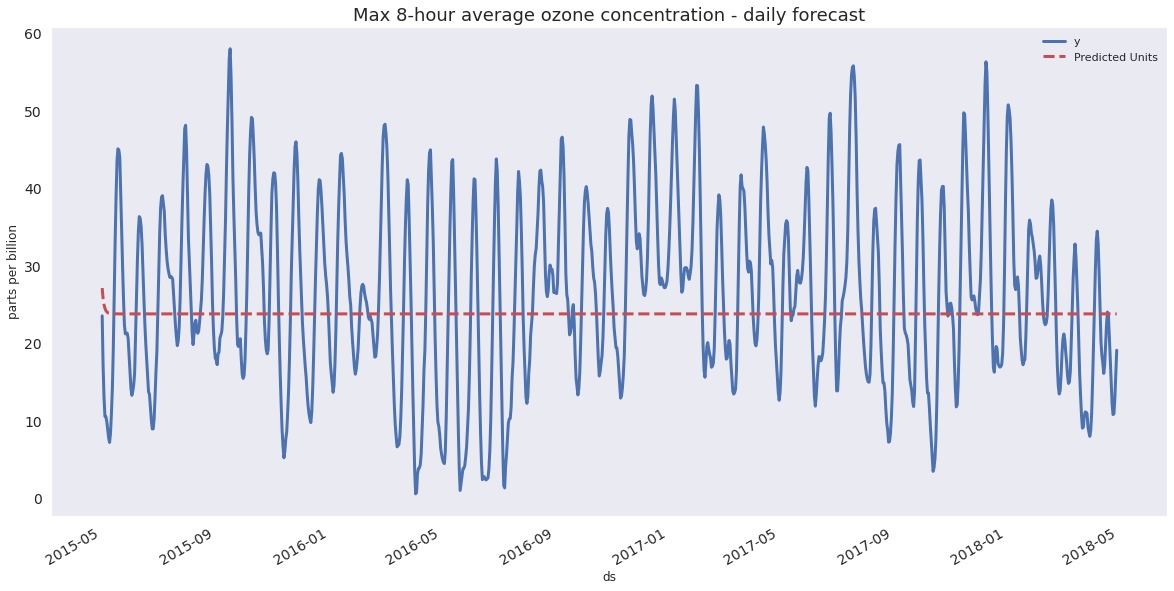

In [58]:
np.expm1(test.y).plot(linewidth=3)
np.expm1(test.yhat_ARIMA).plot(color='r', ls='--', label='Predicted Units', linewidth=3)

plt.legend()
plt.grid()
plt.title('Max 8-hour average ozone concentration - daily forecast')
plt.ylabel('parts per billion')

In [59]:
test['e'] = test.y - test.yhat_ARIMA

rmse = np.round(np.sqrt(np.mean(test.e**2)),2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 2)
print('RMSE =', rmse)
print('MAPE =', mape, '%')

RMSE = 0.55
MAPE = 16.45 %


*Compare this two model.................*

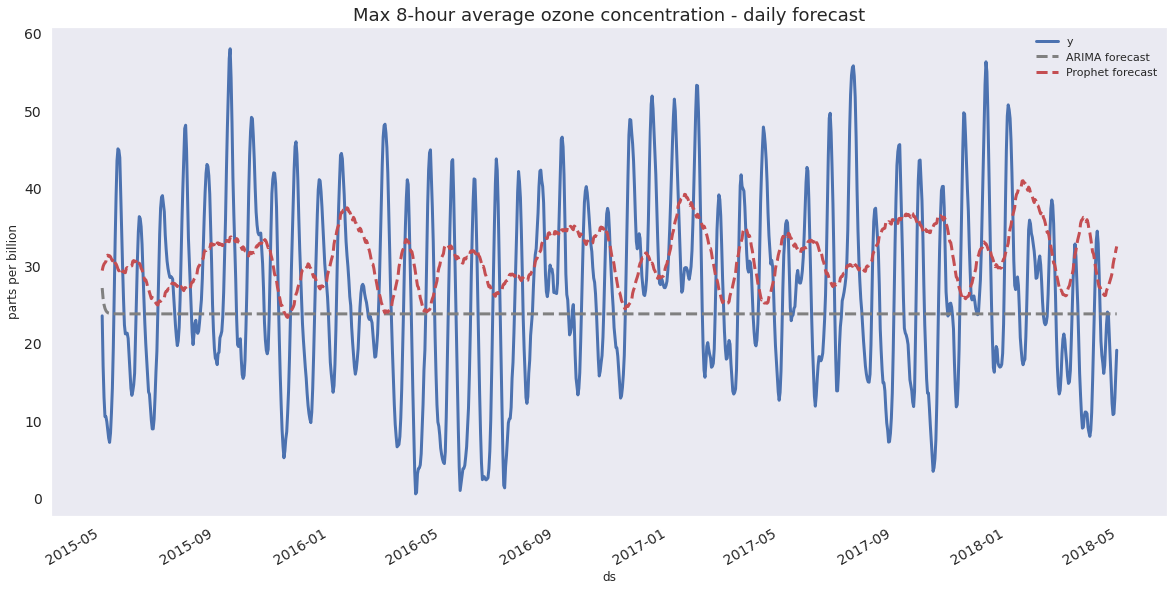

In [65]:
np.expm1(test.y).plot(linewidth=3)

np.expm1(test.yhat_ARIMA).plot(color='grey', ls='--', label='ARIMA forecast', linewidth=3)
np.expm1(test.yhat).plot(color='r', ls='--', label='Prophet forecast', linewidth=3)

plt.legend()
plt.grid()
plt.title('Max 8-hour average ozone concentration - daily forecast')
plt.ylabel('parts per billion');

In [66]:
test.tail()

,y,yhat,yhat_lower,yhat_upper,e,yhat_ARIMA
ds,,,,,,
2018-04-26 01:00:00,2.465183,3.437565,2.630429,4.188188,-0.744227,3.20941
2018-04-27 01:00:00,2.475413,3.458398,2.733982,4.174380,-0.733997,3.20941
2018-04-28 01:00:00,2.633942,3.471910,2.738377,4.156444,-0.575468,3.20941
2018-04-29 01:00:00,2.827322,3.494431,2.774937,4.232745,-0.382088,3.20941
2018-04-30 01:00:00,2.999530,3.510544,2.771130,4.171581,-0.209880,3.20941


Modelling using LSTM..................

In [60]:
def create_lstm(offset, neurons=(2,1), batch_size=32, lr=0.005, n_features=1):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(
        neurons[0], return_sequences=True, stateful=True, 
        batch_input_shape=(batch_size, offset, n_features))
    )
    
    
    # Second LSTM layer if defined
    if neurons[1]:
        model.add(LSTM(
            neurons[1], return_sequences=True, stateful=True, 
            batch_input_shape=(batch_size, offset, n_features))
        )
    
    # TimeDistributed layer to generate all the timesteps
    model.add(TimeDistributed(Dense(1)))
    
    optimizer = RMSprop(lr=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

*Since the model is stateful, we want to reset the state of the network after each epoch. This does not erase the weights learned, instead it just resets the state to be fed via the context neurons. To do so, we can define a function to perform this workaround........*

In [61]:
def train_model(model, X_train, y_train, batch_size=32, epochs=20):
    mse = list()

    for i in range(epochs):
        if i % 1 == 0:
            print('Epoch {:02d}/{}...'.format(i + 1, epochs), end=' ')

        log = model.fit(
            X_train, y_train, 
            epochs=1, batch_size=32, 
            verbose=0, shuffle=False
        )
    
        mse.append(log.history['loss'][-1])
        print('loss: {:.4f}'.format(mse[-1]))
    
        model.reset_states()
        
    return model, mse

In [62]:
def validate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    model.reset_states()
    return np.mean((y_test - preds) ** 2)

In [63]:
model = create_lstm(offset)
model, _ = train_model(model, X_train, y_train)

model.fit(
    X_train, y_train, 
    epochs=1, batch_size=32, 
    verbose=1, shuffle=False
)
model.reset_states()

preds = model.predict(X_test)

Epoch 01/20... loss: 0.0184
Epoch 02/20... loss: 0.0117
Epoch 03/20... loss: 0.0107
Epoch 04/20... loss: 0.0107
Epoch 05/20... loss: 0.0106
Epoch 06/20... loss: 0.0106
Epoch 07/20... loss: 0.0106
Epoch 08/20... loss: 0.0106
Epoch 09/20... loss: 0.0106
Epoch 10/20... loss: 0.0106
Epoch 11/20... loss: 0.0106
Epoch 12/20... loss: 0.0106
Epoch 13/20... loss: 0.0106
Epoch 14/20... loss: 0.0105
Epoch 15/20... loss: 0.0105
Epoch 16/20... loss: 0.0105
Epoch 17/20... loss: 0.0105
Epoch 18/20... loss: 0.0105
Epoch 19/20... loss: 0.0105
Epoch 20/20... loss: 0.0105
316/316 [==============================] - 5s 14ms/step - loss: 0.0105


In [64]:
print('MSE: {:.5f}'.format(validate_model(model, X_test, y_test)))

MSE: 0.01265


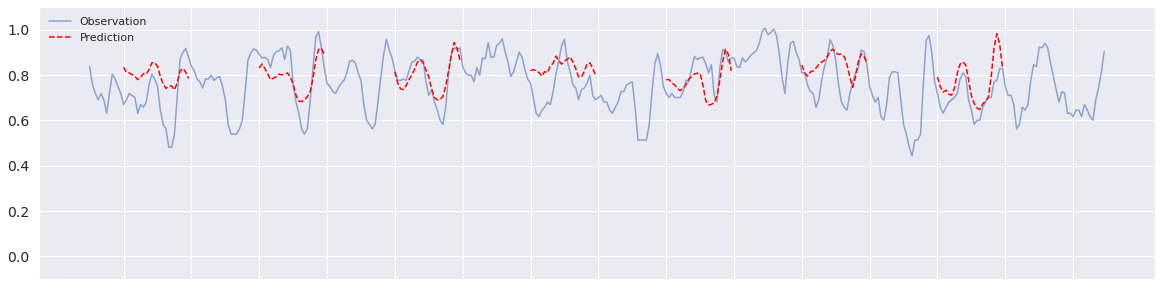

In [67]:
fig, ax = plt.subplots(figsize=(20, 5))

start = X_test.shape[0] - 42
interval = X_test[start+3:start+33:2, :, 0].reshape(-1, 1)

truth, = plt.plot(np.arange(24*15), interval, alpha=0.6)

old_preds = list()

for point in range(1, 15, 2):
    prediction = np.squeeze(preds[start + point*2])
    pred, = plt.plot(point * offset + np.arange(offset) - 12, prediction,
                     linestyle='--', color='red')
    old_preds.append(prediction)

plt.legend(
    [truth, pred],
    ['Observation', 'Prediction']
)
ax.set_ylim([-.1, 1.1])
ax.set_xticks(12 + np.arange(15) * offset)
_ = ax.set_xticklabels([])

Using SARIMAX...................

In [68]:
#Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of seasonal p, d and q  
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal P, D and Q triplets.We select s parameter (stationality) =12, monthly
seasonal_pdq = [(t[0], t[1], t[2], 12) for t in list(itertools.product(p, d, q))]

* Iteration through combinations of parameters.Automated selection of optimal parameters.
* Score selected: AIC(Akaike Information Criterion)
* SARIMAX:Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model


In [69]:
smallest=None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(X,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if smallest is None or results.aic < smallest:
                smallest=results.aic
                valor1=param
                valor2=param_seasonal
                #print(smallest,valor1,valor2)
        except:
            continue
print('Value AIC minimum: ',smallest)
print('Optimal pdq parameters: ',valor1)
print('Optimal PDQS parameteres: ',valor2)      

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:82313.76870830935
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:78457.22559694244
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:73743.22537823577
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:70370.48542009755
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:72870.97363571839
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:70401.68096917492
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:70109.85734242084
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:70101.49929934744
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:73118.95155937553
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:70219.64276679642
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:67914.16826325415
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:64048.55444597453
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:66698.99708504074
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:64104.8490179083
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:64557.84546580508
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:63977.71664676359
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:60404.99709930206
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:60286.63019575321
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:65800.536603

*Diagnostics Graphics................*

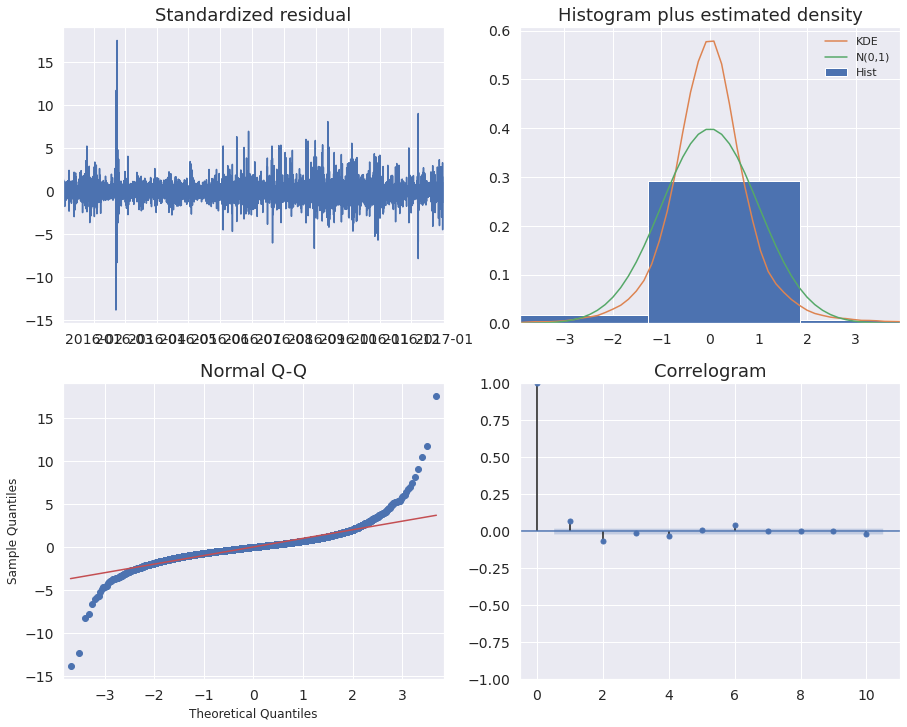

In [70]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

*Selection of optimal parameters to train the model..........*

In [71]:
#valor1=(1,1,1)
#valor2=(1,1,1,12)
mod = sm.tsa.statespace.SARIMAX(X,order=valor1,seasonal_order=valor2,enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=0)
#Prediction of 2016 data
pred_ci = results.predict()
#Elimination of negative values in predictions
for (i, item) in enumerate(pred_ci):
    if item < 0:
        pred_ci[i] = 0
print('Predicted values for 2016',pred_ci)
print('RMSE 2016: %.3f'% sqrt(mean_squared_error(X, pred_ci)))

Predicted values for 2016 2016-01-01 01:00:00     0.000000
2016-01-01 02:00:00    21.487878
2016-01-01 03:00:00    33.114416
2016-01-01 04:00:00    61.110082
2016-01-01 05:00:00    53.060050
                         ...    
2016-12-31 20:00:00    24.498691
2016-12-31 21:00:00    28.133223
2016-12-31 22:00:00    29.993583
2016-12-31 23:00:00    31.919872
2017-01-01 00:00:00    32.871232
Freq: H, Length: 8784, dtype: float64
RMSE 2016: 6.959


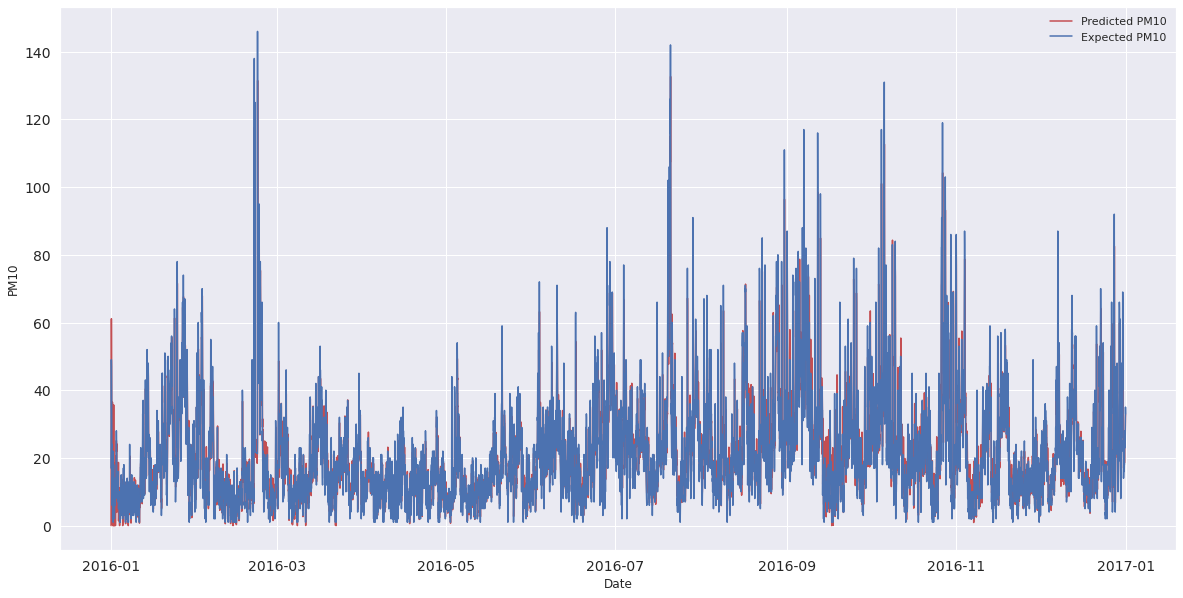

In [72]:
datefmt =matplotlib.dates.DateFormatter("%Y-%m-%d : %H:%M:%S")
fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
plt.rcParams['figure.figsize'] = (20, 10)
plt.gca().format_coord = fmt
plt.xlabel('Date')
plt.ylabel('PM10')
plt.plot(pred_ci,'r',label='Predicted PM10')
plt.plot(X,'b',label='Expected PM10')
plt.legend(loc='best')
plt.show()

*We will repeat the same operations on 2017 year that we have done with 2016 year.........*

In [73]:
series2 = pd.read_csv('../input/air-quality-madrid/csvs_per_year/csvs_per_year/madrid_2017.csv')
station2 = series2[series2['station'] == 28079008].fillna(method='ffill')
station2 = station2[['date', 'PM10']]
station2['date'] = pd.to_datetime(station2['date'])
station2=station2.sort_values(by='date')
station2=station2.reset_index(drop=True)
station2.set_index('date',inplace=True)

In [74]:
myDataset2 = pd.DataFrame(station2['PM10'])
Dataset2 = myDataset2['PM10'].values
Dataset2 = Dataset2.astype('float32')
Dataset2=station2['PM10']
X2=Dataset2
X2.index = pd.DatetimeIndex(X2.index.values,freq=X2.index.inferred_freq)
for (i, item) in enumerate(X2):
    if item > 150:
        X2[i] = np.mean(X2)

In [75]:
#Lists for observations and predictions 
obs2=list()
predictions=list()
mape=list()
fechas=list()
num_dias=335

In [76]:
#Multistep Prediction for December.
mod3 = sm.tsa.statespace.SARIMAX(X,order=valor1,seasonal_order=valor2,enforce_stationarity=False,enforce_invertibility=False)
results3 = mod3.fit(disp=0)
pred3 = results3.get_prediction(start=pd.to_datetime('2016-12-01 01:00:00'),end='2017-01-01 00:00:00', dynamic=False)
truth=list()
predicciones3=list()
i2=0

In [77]:
#2016 was a leap year
for i2 in range((366-num_dias)*24):
        truth.append(X[num_dias*24:][i2])
        predicciones3.append(pred3.predicted_mean[i2])
        if predicciones3[i2] < 0:
            predicciones3[i2] = 1
        fechas.append(X.index[(num_dias*24)+i2])
        #only print first and last day
        if i2 <23:
            print('First day of predictions')
            print('>Predicted=%.3f, Expected =%3.f,Date= %s"} ' % (predicciones3[i2],truth[i2],fechas[i2]))
        if i2>719:
            print('Last day of predictions')
            print('>Predicted=%.3f, Expected =%3.f,Date= %s"} ' % (predicciones3[i2],truth[i2],fechas[i2]))
RMSE2016=sqrt(mean_squared_error(truth, predicciones3))            
print('RMSE December 2016: %.3f'% RMSE2016)

First day of predictions
>Predicted=9.785, Expected =  5,Date= 2016-12-01 01:00:00"} 
First day of predictions
>Predicted=5.346, Expected =  5,Date= 2016-12-01 02:00:00"} 
First day of predictions
>Predicted=5.487, Expected = 13,Date= 2016-12-01 03:00:00"} 
First day of predictions
>Predicted=10.044, Expected =  3,Date= 2016-12-01 04:00:00"} 
First day of predictions
>Predicted=3.104, Expected =  8,Date= 2016-12-01 05:00:00"} 
First day of predictions
>Predicted=8.179, Expected =  6,Date= 2016-12-01 06:00:00"} 
First day of predictions
>Predicted=6.399, Expected =  3,Date= 2016-12-01 07:00:00"} 
First day of predictions
>Predicted=5.977, Expected =  5,Date= 2016-12-01 08:00:00"} 
First day of predictions
>Predicted=9.074, Expected = 10,Date= 2016-12-01 09:00:00"} 
First day of predictions
>Predicted=13.147, Expected = 11,Date= 2016-12-01 10:00:00"} 
First day of predictions
>Predicted=11.540, Expected = 18,Date= 2016-12-01 11:00:00"} 
First day of predictions
>Predicted=14.852, Expecte

*Accuracy Calculation between calculations and predictions with an acceptance.............*

In [78]:
def myAccuracy(predictions, truth, acceptance = 0):
    total = len(predictions)
    errors = 0
    for i in range(total):
        if abs(truth[i] - predictions[i] > acceptance):
            errors += 1
    return (total-errors)/total
accuracy_array = list()
smallest2=None
greatest2=None
i3=0

Accuracy mean,max and min 83.4773425499232 95.96774193548387 55.77956989247311
Accuracy max with acceptance  95.96774193548387 13
Accuracy min with acceptance  55.77956989247311 0
Accuracy for an acceptance equals RMSE:  0.9018817204301075


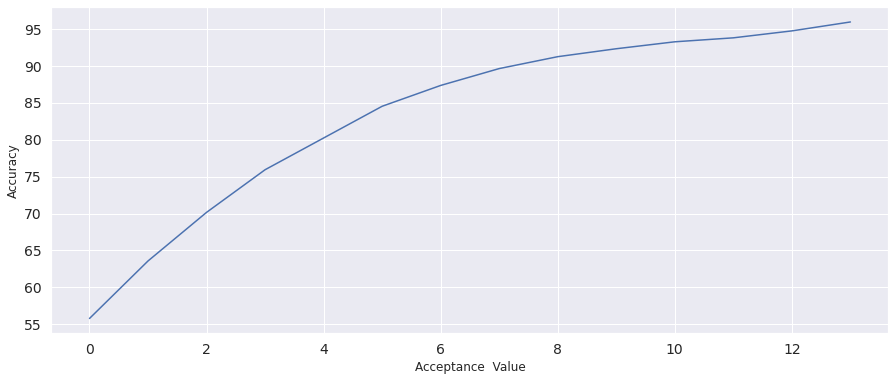

In [79]:
# Acceptance range less than 2*RMSE
for acceptance in range(0, 2*int(RMSE2016)):
    i3=i3+1
    accuracy_array.append(myAccuracy(predicciones3, truth, acceptance) * 100)
    if smallest2 is None or accuracy_array[i3-1] < smallest2:
                smallest2=accuracy_array[i3-1]
                valor10=acceptance
    if greatest2 is None or accuracy_array[i3-1] > greatest2:
                greatest2=accuracy_array[i3-1]
                valor20=acceptance
            
accuracy_array = np.array(accuracy_array)
print('Accuracy mean,max and min',np.mean(accuracy_array),np.max(accuracy_array),np.min(accuracy_array))
print('Accuracy max with acceptance ',greatest2,valor20)
print('Accuracy min with acceptance ',smallest2,valor10)
accuracy_value = myAccuracy(predicciones3, truth, sqrt(mean_squared_error(truth, predicciones3)))
print('Accuracy for an acceptance equals RMSE: ', accuracy_value)
fig2 = plt.figure(figsize=(15,6))
plt.plot(accuracy_array)
plt.xlabel('Acceptance  Value')
plt.ylabel('Accuracy')
plt.show()

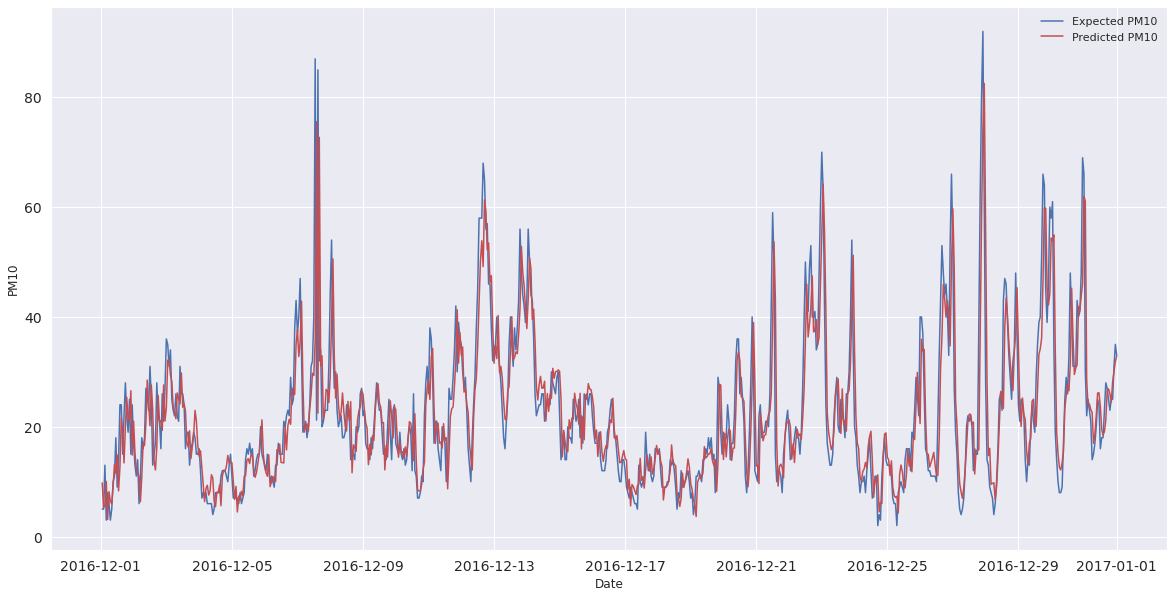

In [80]:
datefmt =matplotlib.dates.DateFormatter("%Y-%m-%d : %H:%M:%S")
fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
plt.rcParams['figure.figsize'] = (20, 10)
plt.gca().format_coord = fmt
plt.xlabel('Date')
plt.ylabel('PM10')
plt.plot(fechas,truth,'b',label='Expected PM10')
plt.plot(fechas,predicciones3,'r',label='Predicted PM10')
plt.legend(loc='best')
plt.show()

*Onestep rolling prediction for the first week of 2017.............*

In [ ]:
num_dias2=7
fechas2=list()
for i in range(0, num_dias2*24):
    mod2 = sm.tsa.statespace.SARIMAX(history,order=valor1,seasonal_order=valor2,enforce_stationarity=False,enforce_invertibility=False)
    results = mod2.fit(disp=0)
    # prediction for t+1
    ypred = results.forecast()[0]
    if ypred < 0:
            ypred = 1
    predictions.append(ypred)
    # expected value
    obs2.append(X2[i])
    #mape calculation
    mape.append(abs((obs2[i]-ypred)/obs2[i]))
    history.append(obs2[i])
    fechas2.append(X2.index[i])
    print('>Predicted=%.3f, Expected =%3.f,Date= %s"} ' % (ypred, obs2[i],fechas2[i]))
    
rmse = sqrt(mean_squared_error(obs2, predictions))
mape_a=np.mean(mape)
print('MAPE error',mape_a)
print('Onestep Prediction RMSE 2017: %.3f' % rmse)

In [ ]:
datefmt =matplotlib.dates.DateFormatter("%Y-%m-%d : %H:%M:%S")
fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
plt.rcParams['figure.figsize'] = (20, 10)
plt.gca().format_coord = fmt
plt.xlabel('Date')
plt.ylabel('PM10')
plt.plot(fechas2,obs2,'b',label='Expected PM10')
plt.plot(fechas2,predictions,'r',label='Predicted PM10')
plt.legend(loc='best')
plt.show()

In [ ]:
#https://www.kaggle.com/dhimananubhav/forecasting-ozone-levels-in-madrid/notebook
#https://www.kaggle.com/diegovicente/particle-levels-prediction-using-lstm
#https://www.kaggle.com/joxemi/sarimax-time-series-prediction-of-pm10